In [1]:
%matplotlib inline

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix


import enum
from typing import List, Dict

In [2]:
class SVMLabels(enum.Enum):
    other = 0
    hot_engine = 1

In [3]:
plt.rcParams['figure.figsize'] = [18, 16]

fram_ir_dir = './frame-ir'

AxisVector = List[plt.Axes]
SVMLabel_type = List[int]

std_threshold = 10.0

svm_train_data = []
svm_train_labels = []


In [4]:
def load_images():
    positive_img = []
    negative_img = []
    for root, dirs, files in os.walk(fram_ir_dir, topdown=True):
        for name in files:
            if root == os.path.join(fram_ir_dir, 'positive'):
                positive_img.append(os.path.join(root, name))
            if root == os.path.join(fram_ir_dir, 'negative'):
                negative_img.append(os.path.join(root, name))

    positive_img.sort()
    negative_img.sort()
    return positive_img, negative_img

In [5]:
def read_img(img_name: str):
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    return img

In [6]:
def equalize_img(img: np.ndarray):
    return cv2.equalizeHist(img)

In [7]:
def CLAHE_equalization(img: np.ndarray):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)

In [8]:
def shrink_image(img: np.ndarray, step: int = 15):
    col_idx = [col for col in range(0, np.shape(img)[1], step)]
    img_shrink = img[:, col_idx]
    return img_shrink

In [9]:
def remove_still_img_column(img: np.ndarray):
    col_above_threshold = [img[:, id_shrink] for id_shrink in range(img.shape[1]) if
                           np.std(img[:, id_shrink]) > std_threshold]

    img_clean = np.asarray(col_above_threshold)
    img_clean = np.swapaxes(img_clean, 0, 1)
    return img_clean

In [10]:
def split_image(img: np.ndarray, ratio: float, offset: float):
    num_row = img.shape[0]
    low_limit = int(np.floor(offset * num_row))
    up_limit = int(np.floor((ratio + offset) * num_row))
    if low_limit > up_limit:
        low_limit, up_limit = up_limit, low_limit
    return img[low_limit:up_limit, :]

In [11]:
def plot_img_and_hist(img: np.ndarray,
                      img_array_hist: np.ndarray,
                      fig: plt.Figure,
                      axes_img: plt.Axes,
                      axes_hist: plt.Axes) -> (np.ndarray, np.ndarray):
    
    axes_img.imshow(img)
    n, bins, _ = axes_hist.hist(img_array_hist, bins=10, range=(150,255), color='#95d0fc')
    
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    axes_hist.axvline(x=np.average(bin_centers, weights=n), linewidth=8, color='blue')
    
    for count, x in zip(n, bin_centers):
        # Label the raw counts
        axes_hist.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
                           xytext=(0, 68), textcoords='offset points', va='top', ha='center')
        
    return n, bins, bin_centers

In [12]:
def processing_image(image_path: str,
                     img_label: SVMLabels,
                     fig: plt.Figure,
                     axis: AxisVector) -> (np.ndarray, np.ndarray):
    
    img_name = image_path[-7:-4]
    img = read_img(image_path)
    img = equalize_img(img)
    img_shrink = shrink_image(img)
    img_shrink_clean = remove_still_img_column(img_shrink)
    
    template_str = "IMG: {0} {1}\tvalue {2:.1f}\tat bin {3} ({4})\tmean {5:.2f}\tLabel {6}"
    
    # UP Section
    up_img_split = split_image(img, 0.3, 0)
    up_shrink_img = split_image(img_shrink_clean, 0.3, 0)
    up_shrink_array = np.asarray(up_shrink_img).ravel()
    
    n, bins, bin_centers = plot_img_and_hist(up_img_split, up_shrink_array, fig, axis[0], axis[1])
    print(template_str.format(img_name,
                              'UP',
                              np.max(n),
                              n.argmax(),
                              bins[n.argmax()],
                              np.average(bin_centers, weights=n),
                              SVMLabels.other.name))
    
    svm_train_data.append(n)
    svm_train_labels.append(SVMLabels.other.value)
    
    # DOWN Section
    down_img_split = split_image(img, 0.3, 0.7)
    down_shrink_img = split_image(img_shrink_clean, 0.3, 0.7)
    down_shrink_array = np.asarray(down_shrink_img).ravel()
    
    n, bins, bin_centers = plot_img_and_hist(down_img_split, down_shrink_array, fig, axis[2], axis[3])
    print(template_str.format(img_name,
                              'DOWN',
                              np.max(n),
                              n.argmax(),
                              bins[n.argmax()],
                              np.average(bin_centers, weights=n),
                              img_label.name))
    
    svm_train_data.append(n)
    svm_train_labels.append(img_label.value)

In [13]:
def extract_car_sample(index: int) -> Dict:
    svm_test_data = []
    svm_test_labels = []
    svm_train_data_pop = svm_train_data.copy()
    svm_train_labels_pop = svm_train_labels.copy()

    if index % 2 == 0:
        svm_test_data.append(svm_train_data[index])
        svm_test_labels.append(svm_train_labels[index])
        svm_train_data_pop.pop(index)
        svm_train_labels_pop.pop(index)

        svm_test_data.append(svm_train_data[index + 1])
        svm_test_labels.append(svm_train_labels[index + 1])
        svm_train_data_pop.pop(index + 1)
        svm_train_labels_pop.pop(index + 1)

    elif index % 2 == 1:
        svm_test_data.append(svm_train_data[index - 1])
        svm_test_labels.append(svm_train_labels[index - 1])
        svm_train_data_pop.pop(index - 1)
        svm_train_labels_pop.pop(index - 1)

        svm_test_data.append(svm_train_data[index])
        svm_test_labels.append(svm_train_labels[index])
        svm_train_data_pop.pop(index)
        svm_train_labels_pop.pop(index)

    svm_sample = {
        'train_data': svm_train_data_pop,
        'train_labels': svm_train_labels_pop,
        'test_data': svm_test_data,
        'test_labels': svm_test_labels
    }

    return svm_sample

In [14]:
def test_with_all_image() -> SVMLabel_type:
    predicted_label = []
    for test_index, test_data in enumerate(svm_train_data, 0):
        test_label = svm_train_labels[test_index]
        svm_train_data_pop = svm_train_data.copy()
        svm_train_labels_pop = svm_train_labels.copy()
        svm_train_data_pop.pop(test_index)
        svm_train_labels_pop.pop(test_index)

        clf = svm.SVC(kernel='linear', gamma='scale')
        clf.fit(svm_train_data_pop, svm_train_labels_pop)

        # prediction
        prediction = clf.predict([test_data])
        predicted_label.append(SVMLabels(prediction[0]).value)
        
        template_str = "Testing index {:2d}\tTruth {:10}\tPredicted {:10}"
        if SVMLabels(test_label).name == SVMLabels(prediction[0]).name:
            template_str += "\tCorrect!"
        
        print(template_str.format(test_index,SVMLabels(test_label).name,SVMLabels(prediction[0]).name))
        
        if test_index == 13:
            print(100*"-")
                
    return predicted_label

In [30]:
# load images
positive_img, negative_img = load_images()
n_pos = len(positive_img)
n_neg = len(negative_img)

Peak POSITIVE histogram
IMG: 001 UP	value 163.0	at bin 7 (223.5)	mean 203.03	Label other
IMG: 001 DOWN	value 154.0	at bin 9 (244.5)	mean 224.51	Label hot_engine
IMG: 002 UP	value 67.0	at bin 3 (181.5)	mean 198.39	Label other
IMG: 002 DOWN	value 104.0	at bin 9 (244.5)	mean 234.64	Label hot_engine
IMG: 003 UP	value 75.0	at bin 3 (181.5)	mean 204.16	Label other
IMG: 003 DOWN	value 37.0	at bin 9 (244.5)	mean 208.37	Label hot_engine
IMG: 004 UP	value 62.0	at bin 8 (234.0)	mean 204.93	Label other
IMG: 004 DOWN	value 36.0	at bin 9 (244.5)	mean 219.85	Label hot_engine
IMG: 005 UP	value 31.0	at bin 1 (160.5)	mean 175.66	Label other
IMG: 005 DOWN	value 68.0	at bin 8 (234.0)	mean 229.53	Label hot_engine
IMG: 006 UP	value 24.0	at bin 1 (160.5)	mean 176.89	Label other
IMG: 006 DOWN	value 44.0	at bin 9 (244.5)	mean 223.36	Label hot_engine
IMG: 007 UP	value 31.0	at bin 3 (181.5)	mean 180.64	Label other
IMG: 007 DOWN	value 48.0	at bin 9 (244.5)	mean 216.90	Label hot_engine


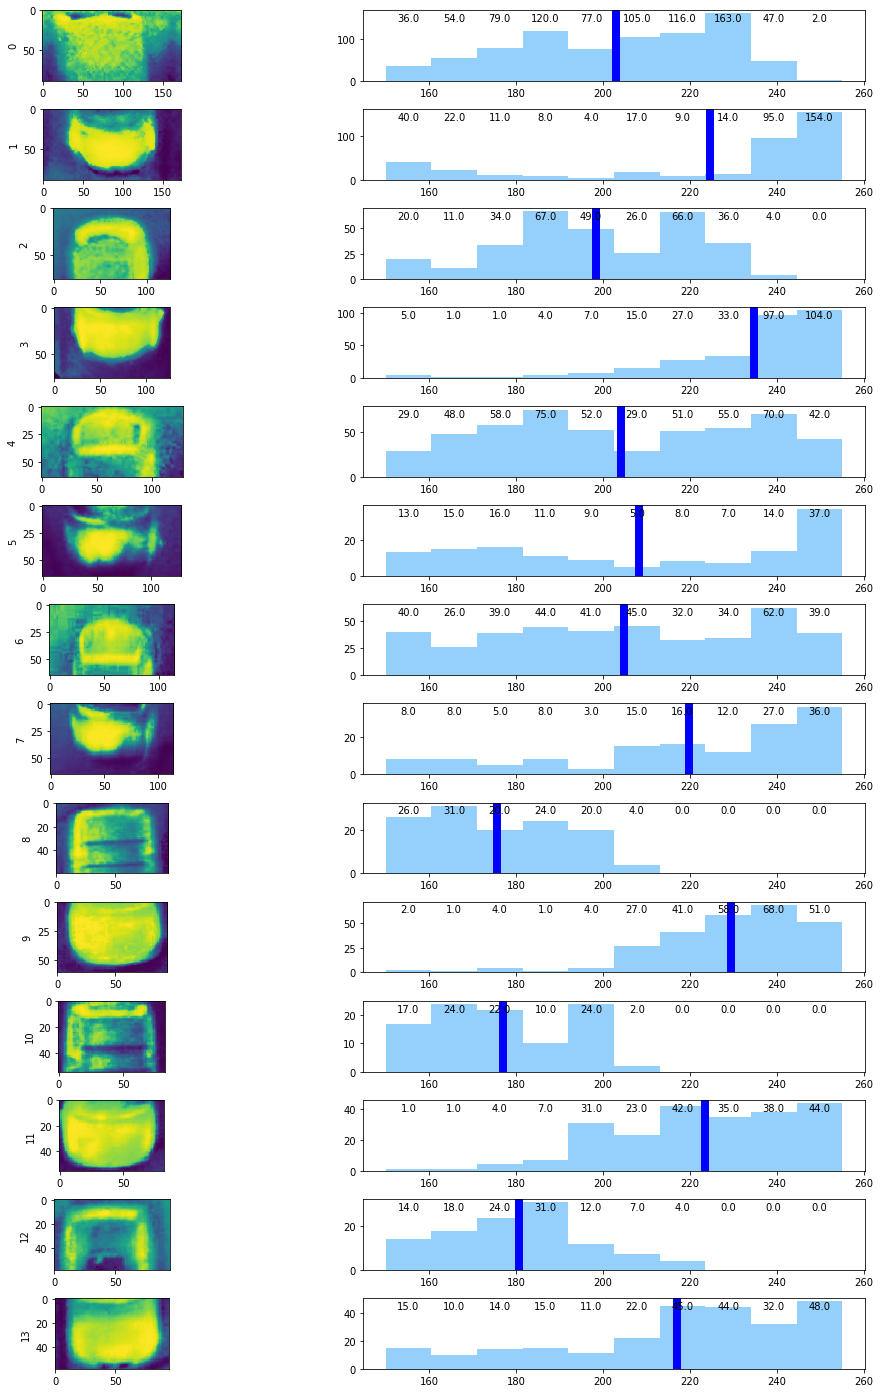

In [16]:
# positive processing

fig_pos, axs_pos = plt.subplots(len(positive_img)* 2, 2)
fig_pos.subplots_adjust(hspace = .4, wspace=0)
fig_pos.set_figheight(25)

print("Peak POSITIVE histogram")
for idx, image_path in enumerate(positive_img, 0):
    axis_list = [axs_pos[idx*2, 0], axs_pos[idx*2, 1],
                 axs_pos[(idx*2)+1, 0], axs_pos[(idx*2)+1, 1]]
    
    processing_image(image_path, SVMLabels.hot_engine, fig_pos, axis_list)
    
    axis_list[0].set_ylabel(str(idx*2))
    axis_list[2].set_ylabel(str(idx*2 +1))

Peak NEGATIVE histogram
IMG: 001 UP	value 138.0	at bin 9 (244.5)	mean 214.00	Label other
IMG: 001 DOWN	value 61.0	at bin 2 (171.0)	mean 175.23	Label other
IMG: 002 UP	value 88.0	at bin 9 (244.5)	mean 204.50	Label other
IMG: 002 DOWN	value 53.0	at bin 0 (150.0)	mean 170.60	Label other
IMG: 003 UP	value 24.0	at bin 7 (223.5)	mean 199.90	Label other
IMG: 003 DOWN	value 26.0	at bin 4 (192.0)	mean 197.88	Label other
IMG: 004 UP	value 28.0	at bin 7 (223.5)	mean 206.85	Label other
IMG: 004 DOWN	value 12.0	at bin 9 (244.5)	mean 218.62	Label other
IMG: 005 UP	value 51.0	at bin 9 (244.5)	mean 218.13	Label other
IMG: 005 DOWN	value 37.0	at bin 5 (202.5)	mean 205.51	Label other
IMG: 006 UP	value 18.0	at bin 4 (192.0)	mean 206.61	Label other
IMG: 006 DOWN	value 35.0	at bin 7 (223.5)	mean 203.45	Label other
IMG: 007 UP	value 28.0	at bin 7 (223.5)	mean 197.98	Label other
IMG: 007 DOWN	value 53.0	at bin 9 (244.5)	mean 216.65	Label other


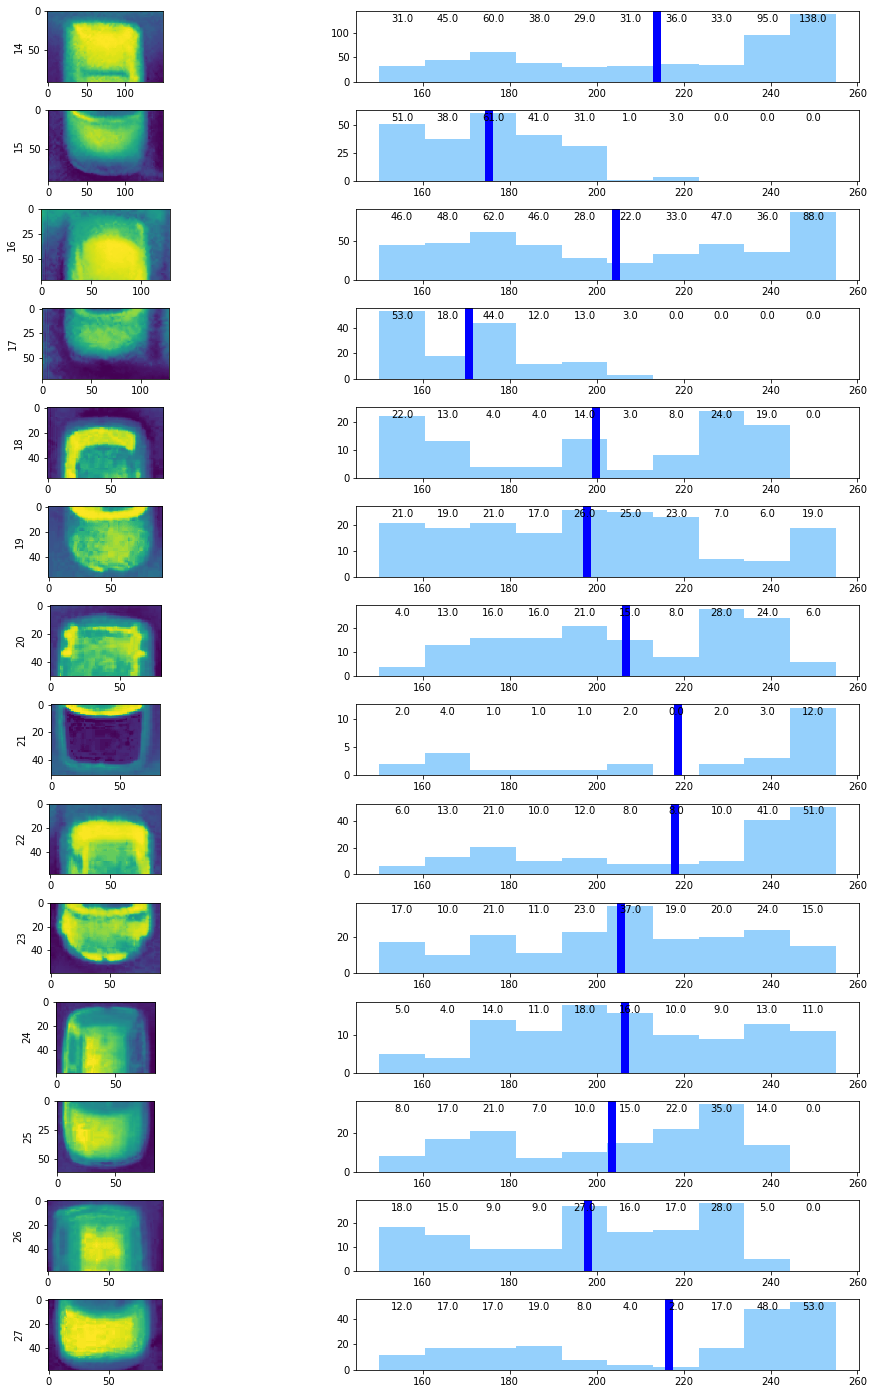

In [17]:
# negative processing

fig_pos, axs_pos = plt.subplots(len(negative_img)* 2, 2)
fig_pos.subplots_adjust(hspace = .4, wspace=0)
fig_pos.set_figheight(25)

indexing_offset = len(positive_img*2)

print("Peak NEGATIVE histogram")
for idx, image_path in enumerate(negative_img, 0):
    axis_list = [axs_pos[idx*2, 0], axs_pos[idx*2, 1],
                 axs_pos[(idx*2)+1, 0], axs_pos[(idx*2)+1, 1]]
    
    processing_image(image_path, SVMLabels.other, fig_pos, axis_list)
    
    axis_list[0].set_ylabel(str(idx*2 +indexing_offset))
    axis_list[2].set_ylabel(str(idx*2 +1 +indexing_offset))

In [39]:
# SVM
# extract some test data
random_index = np.random.randint(len(svm_train_data))
print("Prediction for car: {:2d} - {:10}\t(random index: {})".format(int(random_index/2),
                                                                    'Hot enginge' if random_index<=(n_pos*2) else 'Other',
                                                                    random_index))
svm_sample = extract_car_sample(random_index)

clf = svm.SVC(kernel='linear', gamma='scale')
clf.fit(svm_sample['train_data'], svm_sample['train_labels'])

# prediction
prediction = clf.predict(svm_sample['test_data'])

print("TOP\tTruth label: {:10}\tPredicted label: {}".format(
    SVMLabels(svm_sample['test_labels'][0]).name,
    SVMLabels(prediction[0]).name))

print("BOTTOM\tTruth label: {:10}\tPredicted label: {}".format(
    SVMLabels(svm_sample['test_labels'][1]).name,
    SVMLabels(prediction[1]).name))

Prediction for car:  5 - Hot enginge	(random index: 10)
TOP	Truth label: other     	Predicted label: other
BOTTOM	Truth label: hot_engine	Predicted label: hot_engine


In [19]:
predicted_labels = test_with_all_image()
target_names = ['other', 'hot engine']

print("\n\n", classification_report(svm_train_labels, predicted_labels, target_names=target_names))
print("\n", confusion_matrix(svm_train_labels, predicted_labels, labels=range(len(target_names))))

Testing index  0	Truth other     	Predicted other     	Correct!
Testing index  1	Truth hot_engine	Predicted hot_engine	Correct!
Testing index  2	Truth other     	Predicted hot_engine
Testing index  3	Truth hot_engine	Predicted hot_engine	Correct!
Testing index  4	Truth other     	Predicted other     	Correct!
Testing index  5	Truth hot_engine	Predicted other     
Testing index  6	Truth other     	Predicted other     	Correct!
Testing index  7	Truth hot_engine	Predicted hot_engine	Correct!
Testing index  8	Truth other     	Predicted other     	Correct!
Testing index  9	Truth hot_engine	Predicted other     
Testing index 10	Truth other     	Predicted other     	Correct!
Testing index 11	Truth hot_engine	Predicted hot_engine	Correct!
Testing index 12	Truth other     	Predicted other     	Correct!
Testing index 13	Truth hot_engine	Predicted hot_engine	Correct!
----------------------------------------------------------------------------------------------------
Testing index 14	Truth other  